In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings("ignore")

from fastai.text import *
from fastai import *
from sklearn.metrics import f1_score,accuracy_score
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = True

/kaggle/input/pretrained-models/itos_wt103.pkl
/kaggle/input/pretrained-models/lstm_fwd.pth
/kaggle/input/researchtopictags/sample.csv
/kaggle/input/researchtopictags/test.csv
/kaggle/input/researchtopictags/train.csv


In [2]:
fnames=['/kaggle/input/pretrained-models/lstm_fwd','/kaggle/input/pretrained-models/itos_wt103']

In [3]:
train_data = pd.read_csv('/kaggle/input/researchtopictags/train.csv')
print(train_data.shape)
train_data.head()

(20972, 9)


,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [4]:
test_data = pd.read_csv('/kaggle/input/researchtopictags/test.csv')
print(test_data.shape)
test_data.head()

(8989, 3)


,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...


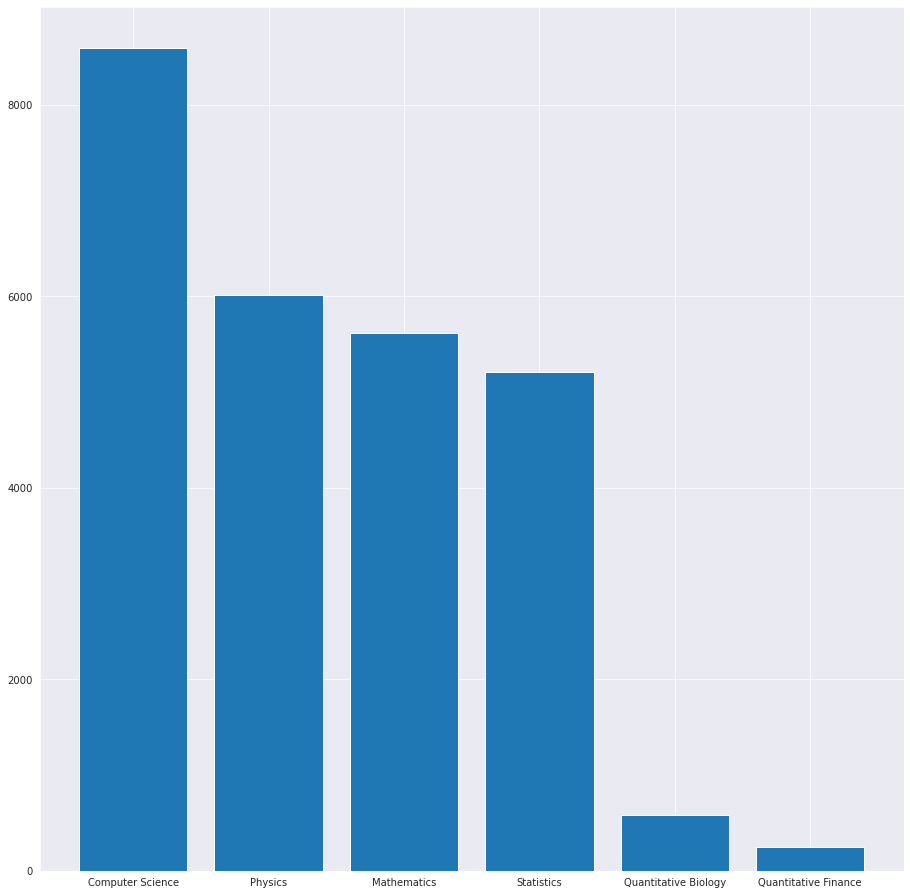

In [5]:
com_sc = train_data['Computer Science'].value_counts()[1]
phy = train_data['Physics'].value_counts()[1]
mat = train_data['Mathematics'].value_counts()[1]
stats = train_data['Statistics'].value_counts()[1]
bio = train_data['Quantitative Biology'].value_counts()[1]
fin = train_data['Quantitative Finance'].value_counts()[1]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
topics = ['Computer Science','Physics','Mathematics', 'Statistics','Quantitative Biology','Quantitative Finance']
counts = [com_sc,phy,mat,stats,bio,fin]
ax.bar(topics,counts)
plt.show()



In [6]:
train_data['combined_text'] = train_data['TITLE'] + "<join>" + train_data['ABSTRACT']
test_data['combined_text'] = test_data['TITLE'] + "<join>" + test_data['ABSTRACT']

In [7]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√']

def clean_text(x):
    x = str(x)
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, ' ')
    return x


train_data['combined_text'] = train_data['combined_text'].apply(lambda x : clean_text(x))
test_data['combined_text'] = test_data['combined_text'].apply(lambda x : clean_text(x))

In [8]:
train_data_lm = (TextList.from_df(df=train_data,cols='combined_text').split_by_rand_pct(0.3).label_for_lm().databunch(bs=48))

In [9]:
train_data_lm.save('train_data_lm.pkl')

In [10]:
train_data_lm.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '\n ']

In [11]:
train_data_lm.train_ds[0][0]

Text [    2     5  4460     5 ... 11747    18    78     9]

In [12]:
train_data_lm = load_data('', 'train_data_lm.pkl', bs=48)

In [13]:
train_data_lm.show_batch()

idx,text
0,xxmaj while global inference is widely \n used local inference which can be used to form subject specific effect maps \n is rarely used because existing models often yield noisy detections composed of \n dispersed isolated islands xxmaj in this article we propose a reconstruction \n method named xxup rsm to improve subject specific detections of predictive \n modeling approaches and in particular binary classifiers
1,line \n xxbos xxmaj stellar streams as gravitational experiments i xxmaj the case of xxmaj sagittarius join xxmaj tidal streams of disrupting dwarf galaxies orbiting around their host galaxy \n offer a unique way to constrain the shape of galactic gravitational potentials \n xxmaj such streams can be used as leaning tower gravitational experiments on galactic \n scales xxmaj the most well motivated modification of gravity
2,additional dataset of over 6 hours of fully annotated \n broadcast material xxmaj the results of our evaluation on the new dataset and three \n other benchmark datasets show that our proposed method significantly \n outperforms the competitors and reduces diarization error rate by a large \n margin of over 30 with respect to the baseline \n xxbos xxmaj enhanced version of adaboostm1 with xxup
3,and susceptible to modes of power driven \n xxunk xxmaj we used the longitudinal dimension of editor activity to develop \n two panel regression models which test and verify the presence of editor level \n bias xxmaj in the first model we analyzed the citation impact of articles and in \n the second model we modeled the decision time between an article being \n submitted
4,relaxation based on the \n difference of convex xxup dc programming and enjoys both strong computational and \n statistical guarantees xxmaj specifically by leveraging a sophisticated \n characterization of sparse modeling structures assumptions i e local \n restricted strong convexity and xxmaj hessian smoothness we prove that within each \n stage of convex relaxation our proposed algorithm achieves local quadratic \n convergence and eventually


In [14]:
languageModel = language_model_learner(train_data_lm, arch=AWD_LSTM, pretrained_fnames=fnames, drop_mult=0.3)

In [15]:
languageModel.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.98E-02
Min loss divided by 10: 1.45E-02


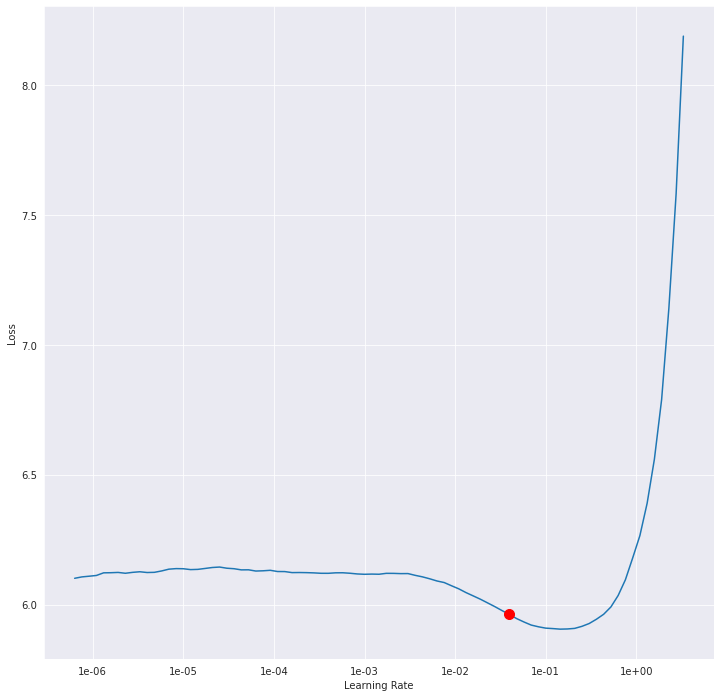

In [16]:
languageModel.recorder.plot(suggestion = True)

In [17]:
min_grad_lr = languageModel.recorder.min_grad_lr
print(min_grad_lr)

0.03981071705534969


In [18]:
languageModel.fit_one_cycle(5, 0.045)

epoch,train_loss,valid_loss,accuracy,time
0,5.029535,4.850693,0.231904,01:56
1,5.123695,4.926432,0.234601,01:56
2,4.870344,4.731266,0.246304,01:55
3,4.418156,4.486864,0.259395,01:56
4,4.078836,4.415239,0.265172,01:56


In [19]:
languageModel.save_encoder('fine_tuned_enc1')

In [20]:
languageModel.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


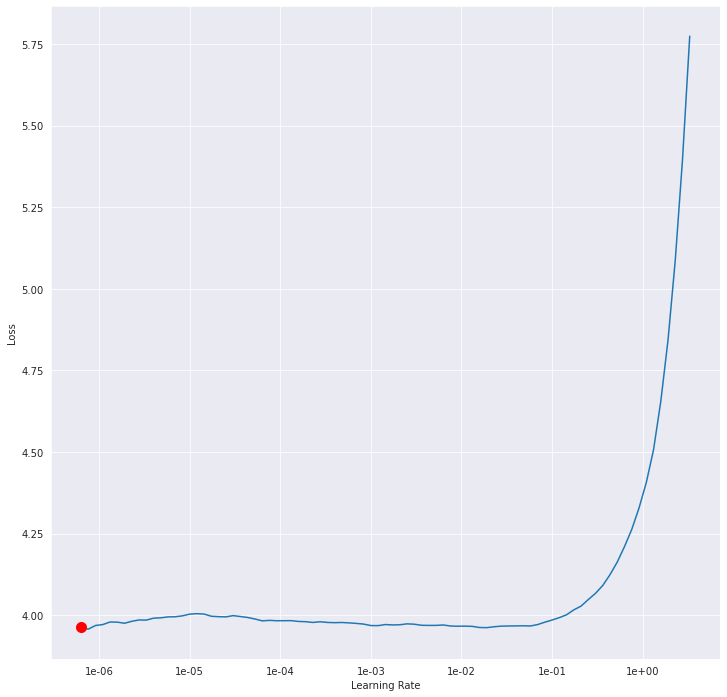

In [21]:
languageModel.recorder.plot(suggestion = True)

In [22]:
min_grad_lr = languageModel.recorder.min_grad_lr
print(min_grad_lr)

6.309573444801933e-07


In [23]:
languageModel.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.091941,4.412242,0.265111,01:56


In [24]:
languageModel.save_encoder('fine_tuned_enc2')

In [25]:
languageModel.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.58E-07


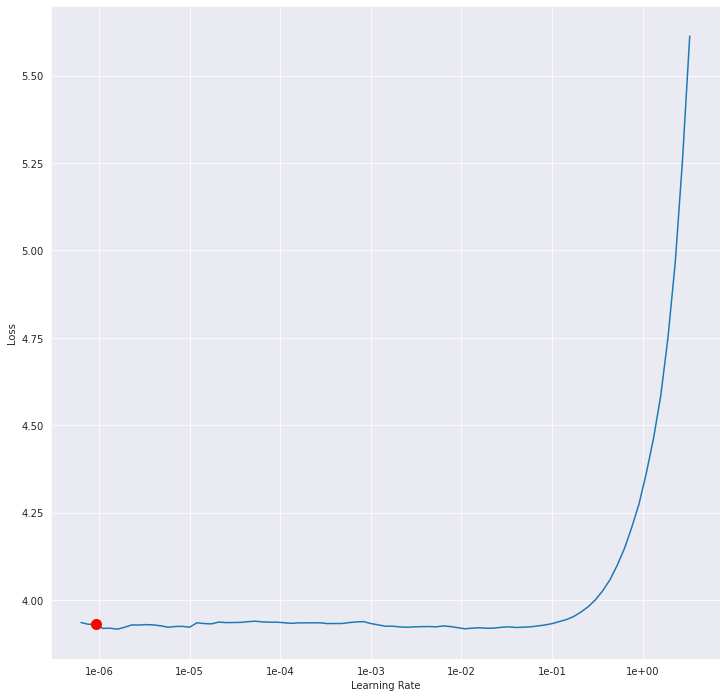

In [26]:
languageModel.recorder.plot(suggestion = True)

In [27]:
min_grad_lr = languageModel.recorder.min_grad_lr
print(min_grad_lr)

9.120108393559096e-07


In [28]:
languageModel.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.064510,4.406788,0.265195,01:56


In [29]:
languageModel.save_encoder('fine_tuned_enc3')

In [30]:
label_cols = topics

In [31]:
data_classifier = (TextList.from_df(df=train_data,cols='combined_text', vocab=train_data_lm.vocab)
                     .split_by_rand_pct(0.3)
                     .label_from_df(label_cols)
                     .add_test(test_data)
                     .databunch(bs=48))

In [32]:
data_classifier.save('data_classifier.pkl')

In [33]:
data_classifier = load_data('','data_classifier.pkl',bs=48)

In [34]:
data_classifier.show_batch()

text,target
xxbos xxmaj the paradox of xxmaj vito xxmaj volterra s predator prey model join xxmaj this article is dedicated to the late xxmaj xxunk xxmaj israel r sum xxmaj the aim \n of this article is to propose on the one hand a brief history of modeling \n starting from the works of xxmaj fibonacci xxmaj xxunk xxmaj xxunk xxmaj pierre xxmaj francis xxmaj xxunk \n and,Quantitative Biology
xxbos xxunk u xxup lirg xxmaj survey xxup xxunk xxmaj dense xxmaj molecular xxmaj gas in xxmaj arp 220 and xxup ngc 6240 join xxmaj aims xxmaj we present new xxup iram xxmaj plateau de xxmaj xxunk xxmaj interferometer observations of xxmaj arp \n 220 in xxup hcn xxup hco xxup xxunk 13 c j 1 0 c 2 h n 1 0 sio j 2 1 xxup xxunk,Physics
xxbos xxup xxunk i xxmaj the molecular gas content in star forming dusty h xxup atlas galaxies up to z 0 35 join xxmaj we present an extragalactic survey using observations from the xxmaj atacama xxmaj large \n xxmaj millimeter submillimeter xxmaj array xxup alma to characterise galaxy populations up to \n z 0 35 the xxmaj xxunk xxup alma xxmaj line xxmaj emission xxmaj survey xxup xxunk,Physics
xxbos xxmaj xxunk sodium ion exchange xxunk complex loaded melt cast films for sustained release xxunk delivery join xxmaj the goal of the present study is to develop polymeric matrix films loaded \n with a combination of free xxunk sodium xxunk and xxup dfs xxmaj ion exchange \n xxunk complexes xxup dfs xxup ir for immediate and sustained release profiles \n respectively xxmaj effect of ratio of,Physics
xxbos xxmaj simulated xxup jwst xxup xxunk xxmaj transit xxmaj spectroscopy of xxmaj anticipated xxup tess xxmaj planets xxmaj compared to xxmaj select xxmaj discoveries from xxmaj space xxmaj based and xxmaj ground xxmaj based xxmaj surveys join xxmaj the xxmaj transiting xxmaj exoplanet xxmaj survey xxmaj satellite xxup tess will xxunk in 2018 on a \n 2 year wide field survey mission discovering over a thousand terrestrial \n,Physics


In [35]:
threshold = 0.2

In [36]:
class MicroF1(Callback):

    _order = -20 #is crucial - without it the custom columns will not be added - it tells the callback system to run this callback before the recorder system.

    def __init__(self,learn,thresh,eps = 1e-15, sigmoid = True,**kwargs):
        self.learn = learn
        self.thresh = thresh
        self.eps = eps
        self.sigmoid = sigmoid

    def on_train_begin(self, **kwargs): 
        self.learn.recorder.add_metric_names(['MicroF1'])
    
    def on_epoch_begin(self, **kwargs):
        self.tp = 0
        self.total_pred = 0
        self.total_targ = 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        pred, targ = ((last_output.sigmoid() if self.sigmoid else last_output) > self.thresh).byte(), last_target.byte()
        if torch.equal(torch.tensor(pred.shape),torch.tensor(targ.shape)):
            
            m = pred*targ
            self.tp += m.sum(0).float()
            self.total_pred += pred.sum(0).float()
            self.total_targ += targ.sum(0).float()
    
    def fbeta_score(self, precision, recall):
        return 2*(precision*recall)/((precision + recall) + self.eps)

    def on_epoch_end(self, last_metrics, **kwargs):
        self.total_pred += self.eps
        self.total_targ += self.eps
        precision, recall = self.tp.sum() / self.total_pred.sum(), self.tp.sum() / self.total_targ.sum()
        res = self.fbeta_score(precision, recall)        
        return add_metrics(last_metrics, res)

In [37]:
class AccPerClass(Callback):
    _order = -20 

    def __init__(self, learn, **kwargs): 
        self.learn = learn
        self.output, self.target = [], []
        
    def on_train_begin(self, **kwargs): 
        self.learn.recorder.add_metric_names(topics)
        
    def on_epoch_begin(self, **kwargs): 
        self.output, self.target = [], []
    
    def on_batch_end(self, last_target, last_output, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_metrics, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            preds = F.softmax(output, dim=1)
            metric = []
            for i in range(0,target.shape[1]):
                metric.append(accuracy_score(target.cpu().numpy()[...,i].flatten(), (preds[...,i] >0.2).byte().cpu().numpy().flatten()))
            return add_metrics(last_metrics, metric)
        else:
            return

In [38]:
microF1 = partial(MicroF1,thresh = threshold)

In [39]:
classifierModel = text_classifier_learner(data_classifier , arch=AWD_LSTM,drop_mult=0.4, callback_fns = [microF1,AccPerClass] )
classifierModel.load_encoder('fine_tuned_enc1')
classifierModel.freeze()

In [40]:
classifierModel.summary()

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [33, 400]            0          False     
______________________________________________________________________
RNNDropout           [33, 1152]           0          False     
______________________________________________________________________
RNNDropout           [33, 1152]           0          False     
______________________________________________________________________
BatchNorm1d          [1200]               2,400      True      
______________________________________________________________________
Dropout              [1200]               0          False     
______________________________________________________________________
Linear               [50]                 60,050     True      
______________________________________________________________________
ReLU                 [50]                 0          False     
________________________________________________

In [41]:
classifierModel.lr_find()

epoch,train_loss,valid_loss,MicroF1,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.20E-01
Min loss divided by 10: 3.63E-02


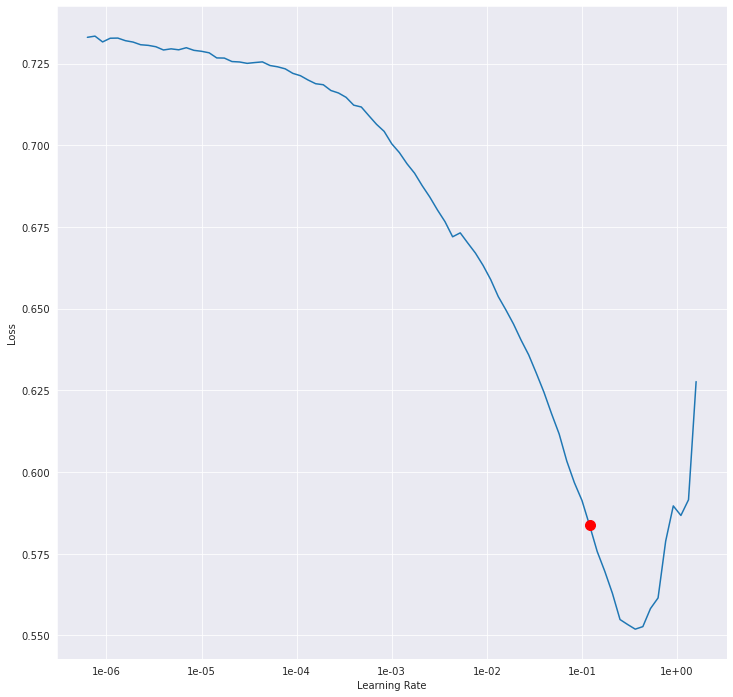

In [42]:
classifierModel.recorder.plot(suggestion = True)

In [43]:
min_grad_lr = classifierModel.recorder.min_grad_lr
print(min_grad_lr)

0.12022644346174131


In [44]:
classifierModel.fit_one_cycle(20, 1e-1)

epoch,train_loss,valid_loss,MicroF1,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,time
0,0.248872,0.193332,0.653981,0.841520,0.925767,0.888412,0.861230,0.975680,0.991734,00:50
1,0.251832,0.192781,0.734416,0.847878,0.907010,0.892068,0.877762,0.974726,0.991416,00:50
2,0.253483,0.197261,0.725856,0.843745,0.920998,0.876013,0.869019,0.974567,0.987442,00:52
3,0.257175,0.195929,0.735198,0.839453,0.923542,0.883961,0.865840,0.975521,0.991257,00:56
4,0.278897,0.227839,0.716329,0.834684,0.920680,0.837546,0.863615,0.973136,0.991257,00:56
5,0.293089,0.228238,0.718673,0.830234,0.927515,0.886187,0.865999,0.973136,0.991257,00:52
6,0.262099,0.205938,0.722521,0.845970,0.928946,0.840089,0.868542,0.974408,0.992052,00:49
7,0.260523,0.215694,0.719928,0.809410,0.931330,0.871880,0.871880,0.973454,0.990304,00:53
8,0.273590,0.245762,0.713334,0.848673,0.852806,0.878716,0.795740,0.973772,0.985058,00:54
9,0.264662,0.205070,0.721299,0.847083,0.923542,0.871245,0.869973,0.974090,0.992688,00:52


In [45]:
classifierModel.save('classifierModel1')

In [46]:
classifierModel.show_results()

text,target,prediction
xxbos xxmaj an introduction to xxmaj topological xxmaj data xxmaj analysis fundamental and practical aspects for data scientists join xxmaj topological xxmaj data xxmaj analysis tda is a recent and fast growing eld providing a \n set of new topological and geometric tools to infer relevant features for \n possibly complex data xxmaj this paper is a brief introduction through a few \n selected topics to basic,Computer Science;Mathematics;Statistics,Computer Science
xxbos xxmaj on the zeros of xxmaj riemann xxunk z function join xxmaj the xxmaj riemann xxmaj xi z function even in z admits a xxmaj fourier transform of an \n even kernel xxmaj phi t xxunk 9 t 2 theta e 2 t xxunk 5 t 2 theta e 2 t xxmaj here \n theta x theta 3 0 ix and theta 3 0 z is a,Mathematics,Mathematics
xxbos xxmaj the xxmaj galactic xxmaj cosmic xxmaj ray xxmaj electron xxmaj spectrum from 3 to 70 mev xxmaj measured by xxmaj voyager 1 xxmaj beyond the xxmaj heliopause xxmaj what xxmaj this xxmaj tells xxmaj us xxmaj about the xxmaj propagation of xxmaj electrons and xxmaj nuclei xxmaj in and xxmaj out of the xxmaj galaxy at xxmaj low xxmaj energies join xxmaj the cosmic ray electrons measured by,Physics,Physics
xxbos xxmaj fast xxmaj switching xxmaj dual xxmaj fabry xxmaj perot xxmaj cavity based xxmaj optical xxmaj xxunk for xxmaj assessment of xxmaj gas xxmaj xxunk and xxmaj density xxmaj estimates of xxmaj its xxmaj precision xxmaj accuracy and xxmaj temperature xxmaj dependence join xxmaj dual xxmaj fabry xxmaj perot xxmaj cavity based xxmaj optical xxmaj xxunk xxup xxunk xxup or have been shown \n to have excellent potential,Physics,Physics
xxbos xxmaj on xxmaj helmholtz free energy for finite abstract simplicial complexes join xxmaj we prove a xxmaj gauss xxmaj bonnet formula x g sum x k x where k x 1 dim x \n 1 x s x is a curvature of a vertex x with unit sphere s x in the \n xxmaj barycentric refinement xxup g1 of a simplicial complex g k x is dual,Computer Science;Mathematics,Mathematics


In [47]:
classifierModel.load('classifierModel1')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (14681 items)
x: TextList
xxbos xxmaj reconstructing xxmaj subject xxmaj specific xxmaj effect xxmaj maps join xxmaj predictive models allow subject specific inference when analyzing disease 
  related alterations in neuroimaging data xxmaj given a subject s data inference can 
  be made at two levels global i e xxunk condition presence for the 
  subject and local i e detecting condition effect on each individual 
  measurement extracted from the subject s data xxmaj while global inference is widely 
  used local inference which can be used to form subject specific effect maps 
  is rarely used because existing models often yield noisy detections composed of 
  dispersed isolated islands xxmaj in this article we propose a reconstruction 
  method named xxup rsm to improve subject specific detections of predictive 
  modeling approaches and in particular binary classifiers xxup rsm specifically 
  aims to reduce noise due to sampling

In [48]:
classifierModel.lr_find()

epoch,train_loss,valid_loss,MicroF1,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.74E-04


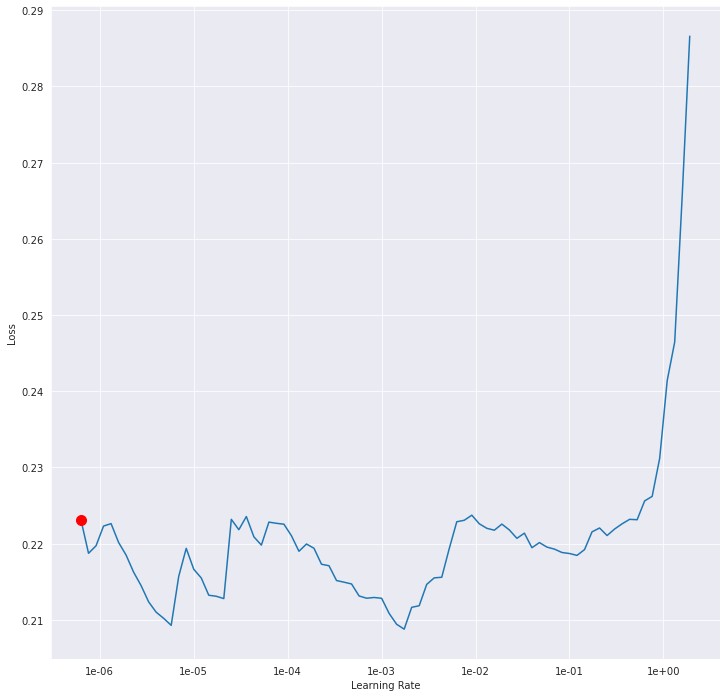

In [49]:
classifierModel.recorder.plot(suggestion = True)

In [50]:
min_grad_lr = classifierModel.recorder.min_grad_lr
print(min_grad_lr)

6.309573444801933e-07


In [51]:
for i in range(2,7):
    classifierModel.freeze_to(-i)
    classifierModel.fit_one_cycle(1,slice((1*10**-(i+1))/(2.6**4),1*10**-(i+1)))
    print ('')

epoch,train_loss,valid_loss,MicroF1,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,time
0,0.221577,0.178742,0.755939,0.853759,0.931489,0.891273,0.882054,0.974726,0.992370,01:00


epoch,train_loss,valid_loss,MicroF1,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,time
0,0.217978,0.180854,0.758735,0.861230,0.930218,0.883007,0.884279,0.974249,0.992052,01:30


epoch,train_loss,valid_loss,MicroF1,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,time
0,0.219559,0.176559,0.759457,0.851693,0.929264,0.893181,0.881418,0.975203,0.992688,01:48


epoch,train_loss,valid_loss,MicroF1,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,time
0,0.214357,0.176170,0.762777,0.854077,0.925290,0.896678,0.881259,0.975203,0.992370,01:50


epoch,train_loss,valid_loss,MicroF1,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,time
0,0.206107,0.179577,0.759950,0.853282,0.933874,0.890161,0.881100,0.974885,0.992211,01:51


In [52]:
classifierModel.save('classifierModel2')

In [53]:
preds = classifierModel.get_preds(DatasetType.Test)

In [54]:
submission = pd.read_csv('/kaggle/input/researchtopictags/sample.csv')
submission.iloc[:,1:] =  (preds[0]>0.3).byte().numpy()
submission.to_csv('submission.csv', index=False)
submission.head()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,20973,1,0,1,1,0,0
1,20974,0,1,0,0,0,0
2,20975,1,0,0,0,0,0
3,20976,0,1,0,0,0,0
4,20977,1,0,0,0,0,0
